In [1]:
import matplotlib
import pandas as pd
import censusdata
import openpyxl
import re
import os
import numpy as np

import matplotlib.pyplot as plt
##### CHECK FOR UNUSED IMPORTS

import sklearn.linear_model

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, train_test_split, validation_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, plot_roc_curve, make_scorer, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error, mean_squared_error, recall_score, ConfusionMatrixDisplay


from yellowbrick.classifier import ROCAUC
from yellowbrick.regressor import PredictionError, ResidualsPlot


import seaborn as sns

import category_encoders as ce

from icecream import ic

import geopandas as gpd

In [2]:
harvard_data = pd.read_csv('harvard_data_2010+.csv', index_col=0)
harvard_data

/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,13,14,18,23,28,32,48,56,67,71,72,75,76,77,78,79,80,81,82,83,84,85,86,87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,caseid,uncert,year,month,day,sid,sab,sfips,sicpsr,cname,...,ltype2b,namebsource,v38,v39,v56,v57,v58,v18_20171211,v19_20171211,v19_20160217
3257,294964,NaN,2010,11.0,2.0,1,al,1,41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,294964.0,"BURDINE, GREG","BURDINE, GREG"
3258,294965,NaN,2010,11.0,2.0,1,al,1,41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2221.0,"HANSON, QUINTON","HANSON, QUINTON"
3259,294966,NaN,2010,11.0,2.0,1,al,1,41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,294966.0,WRITEIN,WRITEIN
3260,294967,NaN,2010,11.0,2.0,1,al,1,41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270539.0,"CURTIS, MIKE","CURTIS, MIKE"
3261,294968,NaN,2010,11.0,2.0,1,al,1,41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3249.0,"GREER, LYNN","GREER, LYNN"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378340,378228,NaN,2016,11.0,8.0,50,wy,56,68,natrona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321320.0,"ANDERSON, JAMES LEE",NaN
378341,378230,NaN,2016,11.0,8.0,50,wy,56,68,natrona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,378230.0,SCATTERING,NaN
378342,378223,NaN,2016,11.0,8.0,50,wy,56,68,natrona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,378223.0,"FORD, ROBERT",NaN
378343,378225,NaN,2016,11.0,8.0,50,wy,56,68,natrona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256633.0,"SCOTT, CHARLES K.",NaN


In [3]:
election_data = harvard_data[(harvard_data['year'] >= 2011)][['year', 'sab', 'ddez', 'sen', 'dtype', 'etype', 'cand', 'party', 'exper', 'vote', 'outcome']]

In [4]:
election_data[election_data['sab'] == 'wv']

,year,sab,ddez,sen,dtype,etype,cand,party,exper,vote,outcome
364609,2012,wv,1,0,3.0,g,"jones, ronnie d.",democrat,inc,7128.0,w
364610,2012,wv,1,0,3.0,g,"swartzmiller, randy",democrat,inc,9059.0,w
364611,2012,wv,1,0,3.0,g,"bull, justin",modernrepublican,none,3655.0,l
364612,2012,wv,1,0,3.0,g,"thompson, carl",modernrepublican,none,5134.0,l
364613,2012,wv,2,0,1.0,g,"diserio, phillip w.",democrat,none,3440.0,w
...,...,...,...,...,...,...,...,...,...,...,...
367397,2016,wv,16-1,1,4.0,g,"skinner, stephen",democrat,other,11607.0,l
367398,2016,wv,16-1,1,4.0,g,"rucker, patricia",republican,none,10180.0,w
367399,2016,wv,16-1,1,4.0,g,"rucker, patricia",republican,none,12319.0,w
367400,2016,wv,17-3,1,4.0,g,"palumbo, corey l.",democrat,inc,22781.0,w


In [5]:
county_results = election_data[(election_data['cand'] != 'scattering') & (election_data['etype'] == 'g')&(election_data.drop('vote', axis=1).duplicated(keep=False))].dropna(subset=['vote'])
county_results

,year,sab,ddez,sen,dtype,etype,cand,party,exper,vote,outcome
3730,2014,al,2,0,1.0,g,"betterton, andew (andy)",democrat,none,549.0,l
3731,2014,al,2,0,1.0,g,"betterton, andew (andy)",democrat,none,4675.0,l
3732,2014,al,2,0,1.0,g,"greer, lynn",modernrepublican,inc,1428.0,w
3733,2014,al,2,0,1.0,g,"greer, lynn",modernrepublican,inc,7133.0,w
3736,2014,al,3,0,1.0,g,"black, marcel",democrat,inc,262.0,w
...,...,...,...,...,...,...,...,...,...,...,...
378322,2016,wy,20,1,1.0,g,"agar, wyatt",republican,none,1225.0,w
378323,2016,wy,20,1,1.0,g,"agar, wyatt",republican,none,1817.0,w
378324,2016,wy,20,1,1.0,g,"agar, wyatt",republican,none,3157.0,w
378330,2016,wy,22,1,1.0,g,"kinskey, dave",republican,none,3746.0,w


A large number of races (but not every race) has results split by county as confirmed by a spot check of the above data displaying duplicates in candidate name, year, state, and district. They need to be merged.

In [6]:
county_results.loc[378331].values

array([2016, 'wy', 22, 1, 1.0, 'g', 'kinskey, dave', 'republican', 'none',
       3857.0, 'w'], dtype=object)

In [7]:
pd.Series(index=county_results.loc[3730].index)

/var/folders/gz/fthcl8n50xb9x3ts2d8zdp3w0000gn/T/ipykernel_37980/709868616.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=county_results.loc[3730].index)


year      NaN
sab       NaN
ddez      NaN
sen       NaN
dtype     NaN
etype     NaN
cand      NaN
party     NaN
exper     NaN
vote      NaN
outcome   NaN
dtype: float64

In [8]:
if (county_results.loc[378331].drop('vote').values == county_results.loc[378330].drop('vote').values).all():
    print('poo')

poo


In [9]:
np.sort(np.array(county_results.index))

array([  3730,   3731,   3732, ..., 378324, 378330, 378331])

In [10]:
# election_data.drop(county_results.index)

county_results = county_results.sort_values(['cand', 'year', 'sab', 'ddez', 'sen'])

previous_row = pd.Series(index=county_results.loc[3730].drop(['vote']).index)
vote_total = 0

merged_df = pd.DataFrame()

for i in np.sort(np.array(county_results.index)):
#     print(i)
    if (county_results.loc[i].drop('vote') == previous_row).all():
#         print(county_results.loc[i])
        vote_total += county_results.loc[i]['vote']
        previous_row = county_results.loc[i].drop('vote')
    else:
        previous_row['vote'] = vote_total
        previous_row['original_index'] = i
        merged_df = merged_df.append(previous_row, ignore_index=True)
        
        vote_total = county_results.loc[i]['vote']
        previous_row = county_results.loc[i].drop('vote')
#     print(merged_df)
#     input()
merged_df.head(20)

/var/folders/gz/fthcl8n50xb9x3ts2d8zdp3w0000gn/T/ipykernel_37980/3198757315.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  previous_row = pd.Series(index=county_results.loc[3730].drop(['vote']).index)


,year,sab,ddez,sen,dtype,etype,cand,party,exper,outcome,vote,original_index
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3730.0
1,2014.0,al,2,0.0,1.0,g,"betterton, andew (andy)",democrat,none,l,5224.0,3732.0
2,2014.0,al,2,0.0,1.0,g,"greer, lynn",modernrepublican,inc,w,8561.0,3736.0
3,2014.0,al,3,0.0,1.0,g,"black, marcel",democrat,inc,w,7993.0,3739.0
4,2014.0,al,3,0.0,1.0,g,"joly, fred",modernrepublican,none,l,5357.0,3745.0
5,2014.0,al,4,0.0,1.0,g,"hammon, micky",modernrepublican,inc,w,8473.0,3752.0
6,2014.0,al,6,0.0,1.0,g,"williams, phil 2",modernrepublican,inc,w,8323.0,3756.0
7,2014.0,al,7,0.0,1.0,g,"letson, john (jody)",democrat,pastinc,l,5553.0,3760.0
8,2014.0,al,7,0.0,1.0,g,"johnson, ken",modernrepublican,inc,w,6072.0,3771.0
9,2014.0,al,9,0.0,1.0,g,"henry, ed",modernrepublican,inc,w,9624.0,3779.0


In [11]:
merged_df[merged_df['cand'] == 'betterton, andew (andy)']

,year,sab,ddez,sen,dtype,etype,cand,party,exper,outcome,vote,original_index
1,2014.0,al,2,0.0,1.0,g,"betterton, andew (andy)",democrat,none,l,5224.0,3732.0


In [12]:
election_data_merged = pd.concat([merged_df[1:], election_data.drop(county_results.index)])

election_data_merged

,year,sab,ddez,sen,dtype,etype,cand,party,exper,outcome,vote,original_index
1,2014.0,al,2,0.0,1.0,g,"betterton, andew (andy)",democrat,none,l,5224.0,3732.0
2,2014.0,al,2,0.0,1.0,g,"greer, lynn",modernrepublican,inc,w,8561.0,3736.0
3,2014.0,al,3,0.0,1.0,g,"black, marcel",democrat,inc,w,7993.0,3739.0
4,2014.0,al,3,0.0,1.0,g,"joly, fred",modernrepublican,none,l,5357.0,3745.0
5,2014.0,al,4,0.0,1.0,g,"hammon, micky",modernrepublican,inc,w,8473.0,3752.0
...,...,...,...,...,...,...,...,...,...,...,...,...
378340,2016.0,wy,28,1.0,1.0,g,"anderson, james lee",republican,inc,w,5216.0,NaN
378341,2016.0,wy,28,1.0,1.0,g,scattering,writein,none,l,22.0,NaN
378342,2016.0,wy,30,1.0,1.0,g,"ford, robert",democrat,none,l,1521.0,NaN
378343,2016.0,wy,30,1.0,1.0,g,"scott, charles k.",republican,inc,w,5831.0,NaN


In [13]:
election_data_merged[(election_data_merged['cand'] != 'scattering') & (election_data_merged['etype'] == 'g')&(election_data_merged.drop('vote', axis=1).duplicated(keep=False))].dropna(subset=['vote'])

,year,sab,ddez,sen,dtype,etype,cand,party,exper,outcome,vote,original_index


In [14]:
election_data_merged

,year,sab,ddez,sen,dtype,etype,cand,party,exper,outcome,vote,original_index
1,2014.0,al,2,0.0,1.0,g,"betterton, andew (andy)",democrat,none,l,5224.0,3732.0
2,2014.0,al,2,0.0,1.0,g,"greer, lynn",modernrepublican,inc,w,8561.0,3736.0
3,2014.0,al,3,0.0,1.0,g,"black, marcel",democrat,inc,w,7993.0,3739.0
4,2014.0,al,3,0.0,1.0,g,"joly, fred",modernrepublican,none,l,5357.0,3745.0
5,2014.0,al,4,0.0,1.0,g,"hammon, micky",modernrepublican,inc,w,8473.0,3752.0
...,...,...,...,...,...,...,...,...,...,...,...,...
378340,2016.0,wy,28,1.0,1.0,g,"anderson, james lee",republican,inc,w,5216.0,NaN
378341,2016.0,wy,28,1.0,1.0,g,scattering,writein,none,l,22.0,NaN
378342,2016.0,wy,30,1.0,1.0,g,"ford, robert",democrat,none,l,1521.0,NaN
378343,2016.0,wy,30,1.0,1.0,g,"scott, charles k.",republican,inc,w,5831.0,NaN


# Likely remove in favor of previous winner party

Prior columns are useless for this segment of data though incumbency (expr column) is going to be a huge indicator obviously. For this research I'm going to limit to general elections. Then I'm going to need to combine candidates due to NY's fusion voting system.

In [15]:
election_data_merged = election_data_merged[election_data_merged['etype'] == 'g']
election_data_merged = election_data_merged[['year', 'sab', 'ddez', 'sen', 'cand', 'party', 'exper', 'vote', 'outcome']]
election_data_merged

,year,sab,ddez,sen,cand,party,exper,vote,outcome
1,2014.0,al,2,0.0,"betterton, andew (andy)",democrat,none,5224.0,l
2,2014.0,al,2,0.0,"greer, lynn",modernrepublican,inc,8561.0,w
3,2014.0,al,3,0.0,"black, marcel",democrat,inc,7993.0,w
4,2014.0,al,3,0.0,"joly, fred",modernrepublican,none,5357.0,l
5,2014.0,al,4,0.0,"hammon, micky",modernrepublican,inc,8473.0,w
...,...,...,...,...,...,...,...,...,...
378340,2016.0,wy,28,1.0,"anderson, james lee",republican,inc,5216.0,w
378341,2016.0,wy,28,1.0,scattering,writein,none,22.0,l
378342,2016.0,wy,30,1.0,"ford, robert",democrat,none,1521.0,l
378343,2016.0,wy,30,1.0,"scott, charles k.",republican,inc,5831.0,w


In [16]:
list_of_candidates = election_data_merged['cand'].unique()

list_of_candidates

array(['betterton, andew (andy)', 'greer, lynn', 'black, marcel', ...,
       'anselmidalton, liisa', 'baldwin, cindy', 'lee, chesie'],
      dtype=object)

In [17]:
election_data_merged['year'].value_counts()

2016.0    13128
2014.0    13051
2012.0    11810
2015.0     1107
2011.0      729
2013.0      684
Name: year, dtype: int64

In [18]:
election_data_merged[election_data_merged['cand'] == 'thiele, fred w. jr.'].groupby(['year']).sum()

,sen,vote
year,,
2012.0,0.0,38005.0
2014.0,0.0,19956.0
2016.0,0.0,35246.0


In [19]:
election_data_merged['district'] = election_data_merged.apply(lambda row: ('u' if row['sen'] == 1 else 'l') + '{:0>3}'.format(row['ddez']), axis=1)
election_data_merged

,year,sab,ddez,sen,cand,party,exper,vote,outcome,district
1,2014.0,al,2,0.0,"betterton, andew (andy)",democrat,none,5224.0,l,l002
2,2014.0,al,2,0.0,"greer, lynn",modernrepublican,inc,8561.0,w,l002
3,2014.0,al,3,0.0,"black, marcel",democrat,inc,7993.0,w,l003
4,2014.0,al,3,0.0,"joly, fred",modernrepublican,none,5357.0,l,l003
5,2014.0,al,4,0.0,"hammon, micky",modernrepublican,inc,8473.0,w,l004
...,...,...,...,...,...,...,...,...,...,...
378340,2016.0,wy,28,1.0,"anderson, james lee",republican,inc,5216.0,w,u028
378341,2016.0,wy,28,1.0,scattering,writein,none,22.0,l,u028
378342,2016.0,wy,30,1.0,"ford, robert",democrat,none,1521.0,l,u030
378343,2016.0,wy,30,1.0,"scott, charles k.",republican,inc,5831.0,w,u030


In [20]:
election_data_merged[(election_data_merged['year'] == 2014) & (election_data_merged['ddez'] == '7-B')]

,year,sab,ddez,sen,cand,party,exper,vote,outcome,district
884,2014.0,id,7-B,0.0,"meyers, kenneth murray",democrat,none,3943.0,l,l7-B
885,2014.0,id,7-B,0.0,"shepherd, paul e.",modernrepublican,inc,9216.0,w,l7-B
160784,2014.0,mn,7-B,0.0,"simonson, erik",democratfarmerlabor,inc,9435.0,w,l7-B
160785,2014.0,mn,7-B,0.0,"silvers, travis",modernrepublican,none,3803.0,l,l7-B
160786,2014.0,mn,7-B,0.0,scattering,9999,none,42.0,l,l7-B


In [21]:
sorted([str(x) for x in election_data_merged['party'].unique()])

['4002',
 '4008',
 '5000',
 '9999',
 '99999',
 'americafirst',
 'american',
 'americanconstit',
 'americanindep',
 'americanindependent',
 'berniesandersindependent',
 'c',
 'christiancenter',
 'commonsenseindependent',
 'con',
 'conservative',
 'constitution',
 'constitutional',
 'constitutional/americanindependent',
 'cst',
 'democrat',
 'democrat/progressive',
 'democrat/workingfamilies',
 'democratandrepublican',
 'democratfarmerlabor',
 'democratic',
 'democratic/progressive',
 'democratic/republican',
 'democraticfarmerlabor',
 'democraticparty',
 'democraticrepublican',
 'democraticwritein',
 'democratparty',
 'eliminateprimaryelections',
 'forthepeople',
 'foryourtown',
 'gop/independentparty',
 'gopparty',
 'green',
 'greenindependent',
 'greenparty',
 'greenrainbow',
 'indep',
 'indep39/democratparty',
 'indepamericanparty',
 'independanceparty',
 'independence',
 'independent',
 'independentamerican',
 'independentamericanparty',
 'independentanddemocrat',
 'independentdemoc

In [22]:
election_data_merged[election_data_merged['party'] == 'gop/independentparty']

,year,sab,ddez,sen,cand,party,exper,vote,outcome,district
6634,2016.0,wa,24 Position 2,0.0,"alger, john d.",gop/independentparty,none,30895.0,l,l24 Position 2


In [23]:
republican = ['republican','republican/independent','republicanwritein', 'writeinrepublican', 'modernrepublican', 'independentrepublicanparty', 'independentrepublican', 'gop/independentparty']

democratic = [ 'progressive/democratic/workingfamily',
              'progressive/democratic',
              'writeindemocrat',
              'independentanddemocrat',
             'independentdemocrat',
             'independentdemparty','democrat',
             'democrat/progressive',
             'democrat/workingfamilies',
             'democratfarmerlabor',
             'democratic',
             'democratic/progressive',
             'democraticfarmerlabor',
             'democraticparty',
             'democraticwritein',
             'democratparty'
            ]

In [24]:
election_data_merged[election_data_merged['party'] == 'democraticrepublican']

,year,sab,ddez,sen,cand,party,exper,vote,outcome,district
5413,2016.0,pa,14,0.0,"marshall, jim",democraticrepublican,inc,29499.0,w,l014
5450,2016.0,pa,68,0.0,"baker, matthew e.",democraticrepublican,inc,24920.0,w,l068
5451,2016.0,pa,69,0.0,"metzgar, carl walker",democraticrepublican,inc,28988.0,w,l069
5478,2016.0,pa,117,0.0,"boback, karen",democraticrepublican,inc,24869.0,w,l117
5482,2016.0,pa,124,0.0,"knowles, jerry",democraticrepublican,inc,26187.0,w,l124
5505,2016.0,pa,187,0.0,"day, gary",democraticrepublican,inc,29870.0,w,l187
212723,2016.0,nh,Merrimack 5,0.0,"ebel, karen",democraticrepublican,inc,3488.0,w,lMerrimack 5
213032,2016.0,nh,Strafford 6,0.0,"wall, janet g.",democraticrepublican,inc,8147.0,w,lStrafford 6
213089,2016.0,nh,Strafford 23,0.0,"keans, sandra b.",democraticrepublican,pastinc,4489.0,w,lStrafford 23
290812,2016.0,pa,7,0.0,"longietti, mark",democraticrepublican,inc,27497.0,w,l007


In [25]:
election_data_merged[election_data_merged['party'] == 'democratandrepublican']

,year,sab,ddez,sen,cand,party,exper,vote,outcome,district
3319,2014.0,nh,5,1.0,"pierce, david m.",democratandrepublican,inc,18474.0,w,u005
6175,2014.0,vt,Grandisle-Chittenden,0.0,"krebs, robert c.",democratandrepublican,inc,1864.0,w,lGrandisle-Chittenden
6214,2014.0,vt,Caledonia,1.0,"kitchel, jane",democratandrepublican,inc,7786.0,w,uCaledonia
6217,2014.0,vt,Essex-Orleans,1.0,"starr, robert a. jr.",democratandrepublican,inc,7168.0,w,uEssex-Orleans
6225,2014.0,vt,Grandisle,1.0,"mazza, richard (dick)",democratandrepublican,inc,5603.0,w,uGrandisle
209615,2012.0,nh,Strafford 6,0.0,"wall, janet g.",democratandrepublican,inc,6167.0,w,lStrafford 6
211819,2014.0,nh,Merrimack 5,0.0,"ebel, karen",democratandrepublican,inc,2730.0,w,lMerrimack 5
212111,2014.0,nh,Strafford 6,0.0,"wall, janet g.",democratandrepublican,inc,4228.0,w,lStrafford 6


In [26]:
election_data_merged.loc[211815:211825]

,year,sab,ddez,sen,cand,party,exper,vote,outcome,district
211815,2014.0,nh,Merrimack 3,0.0,"virtue, carolyn a.",modernrepublican,pastinc,934.0,l,lMerrimack 3
211816,2014.0,nh,Merrimack 3,0.0,scattering,9999,none,3.0,l,lMerrimack 3
211817,2014.0,nh,Merrimack 4,0.0,"schamberg, tom",democrat,inc,768.0,l,lMerrimack 4
211818,2014.0,nh,Merrimack 4,0.0,"long, douglas b.",modernrepublican,none,783.0,w,lMerrimack 4
211819,2014.0,nh,Merrimack 5,0.0,"ebel, karen",democratandrepublican,inc,2730.0,w,lMerrimack 5
211820,2014.0,nh,Merrimack 5,0.0,"kidder, david h.",republican/democrat,inc,2895.0,w,lMerrimack 5
211821,2014.0,nh,Merrimack 5,0.0,scattering,9999,none,25.0,l,lMerrimack 5
211822,2014.0,nh,Merrimack 6,0.0,"french, barbara conner",democrat,inc,1298.0,w,lMerrimack 6
211823,2014.0,nh,Merrimack 6,0.0,"hirsch, geoffrey",democrat,inc,1225.0,w,lMerrimack 6
211824,2014.0,nh,Merrimack 6,0.0,"humboldt, riki p.",modernrepublican,none,940.0,l,lMerrimack 6


In [27]:
election_data_merged[election_data_merged['party'] == 'democratic/republican']

,year,sab,ddez,sen,cand,party,exper,vote,outcome,district
341936,2016.0,vt,Franklin 5,0.0,"beyor, steve",democratic/republican,inc,1772.0,w,lFranklin 5
341960,2016.0,vt,Lamoille 3,0.0,"juskiewicz, bernie",democratic/republican,inc,2058.0,w,lLamoille 3
341983,2016.0,vt,Orleans 1,0.0,"smith, brian",democratic/republican,none,2607.0,w,lOrleans 1
342037,2016.0,vt,Washington 2,0.0,"mcfaun, francis (topper)",democratic/republican,inc,2945.0,w,lWashington 2
342041,2016.0,vt,Washington 3,0.0,"walz, tommy j.",democratic/republican,inc,1728.0,w,lWashington 3
342066,2016.0,vt,Windham 1,0.0,"hebert, michael",democratic/republican,inc,1919.0,w,lWindham 1
342100,2016.0,vt,Windsor 3-1,0.0,"bock, thomas a.",democratic/republican,none,1860.0,w,lWindsor 3-1
343223,2016.0,vt,Caledonia,1.0,"benning, joseph c.",democratic/republican,inc,10908.0,w,uCaledonia
343224,2016.0,vt,Caledonia,1.0,"kitchel, jane",democratic/republican,inc,12383.0,w,uCaledonia
343244,2016.0,vt,Grandisle,1.0,"mazza, richard (dick)",democratic/republican,inc,9771.0,w,uGrandisle


In [28]:
election_data_merged = election_data_merged.sort_index()

In [29]:
election_data_merged.loc[343115:343130]

,year,sab,ddez,sen,cand,party,exper,vote,outcome,district
343118,2014.0,vt,Bennington,1.0,scattering,9999,none,4.0,l,uBennington
343119,2014.0,vt,Bennington,1.0,scattering,9999,none,27.0,l,uBennington
343126,2014.0,vt,Caledonia,1.0,scattering,9999,none,7.0,l,uCaledonia
343127,2014.0,vt,Caledonia,1.0,scattering,9999,none,52.0,l,uCaledonia
343128,2014.0,vt,Chittenden,1.0,"ashe, tim",democrat/progressive,inc,22790.0,w,uChittenden
343129,2014.0,vt,Chittenden,1.0,"baruth, philip",democrat,inc,22217.0,w,uChittenden
343130,2014.0,vt,Chittenden,1.0,"ellis, dawn",democrat,none,18432.0,l,uChittenden


Mixed democrats and republicans

As far as I can tell all democratic republican combinations are cross endorsed. Elections where they appear should be removed from dataset.

In [30]:
election_data_merged[election_data_merged['party'] == 'democraticwritein']

,year,sab,ddez,sen,cand,party,exper,vote,outcome,district
150,2014.0,az,11,0.0,"mccain, barry",democraticwritein,none,49.0,l,l011
2401,2014.0,md,37,1.0,"nance, taren james",democraticwritein,none,4.0,l,u037
3629,2014.0,nm,5,0.0,"jeff, sandra d.",democraticwritein,inc,763.0,l,l005
3631,2014.0,nm,6,0.0,"chimoni, shelly c.",democraticwritein,none,69.0,l,l006
7050,2014.0,wi,60,0.0,"duman, perry",democraticwritein,none,5.0,l,l060
11241,2012.0,az,16,0.0,"prior, cara",democraticwritein,none,234.0,l,l016
28786,2016.0,co,32,0.0,"zorn, steve",democraticwritein,none,10.0,l,l032
38135,2016.0,ct,1,0.0,"fonfara, john w.",democraticwritein,other,60.0,l,l001
40720,2016.0,ct,1,1.0,"ritter, matthew",democraticwritein,other,60.0,l,u001
124857,2012.0,me,34,0.0,"morison, arthur m.",democraticwritein,none,568.0,l,l034


In [31]:
election_data_merged.loc[372034:372049]

,year,sab,ddez,sen,cand,party,exper,vote,outcome,district
372034,2012.0,wi,5,0.0,"mccabe, jeff",democrat,none,12709.0,l,l005
372035,2012.0,wi,5,0.0,"steineke, jim",modernrepublican,inc,16117.0,w,l005
372036,2012.0,wi,5,0.0,scattering,independentwritein,none,24.0,l,l005
372037,2012.0,wi,6,0.0,"powers, john",democrat,none,10508.0,l,l006
372038,2012.0,wi,6,0.0,"tauchen, gary",modernrepublican,inc,15423.0,w,l006
372039,2012.0,wi,6,0.0,"kupsky, jon",independentwritein,none,9.0,l,l006
372040,2012.0,wi,6,0.0,scattering,independentwritein,none,21.0,l,l006
372041,2012.0,wi,7,0.0,"riemer, daniel",democrat,none,16664.0,w,l007
372042,2012.0,wi,7,0.0,"koehler, tiffany lee",independentwritein,none,2.0,l,l007
372043,2012.0,wi,7,0.0,"krusick, margaret ann",democraticwritein,inc,2499.0,l,l007


Let's count democraticwritein ONLY when there's no democrat or democratic-republican candidate. Count republicanwritein ONLY when there's no republican or democratic-republican candidate.

Need to combine rows so each row represents one general election. Vote feature should be net democratic votes


In [32]:
# need to include outcome because we can't simply rely on vote totals because a number of new england states have multimember districts

election_data_merged = election_data_merged[['year', 'sab', 'cand', 'party', 'exper', 'vote', 'outcome', 'district']]
election_data_merged

,year,sab,cand,party,exper,vote,outcome,district
1,2014.0,al,"betterton, andew (andy)",democrat,none,5224.0,l,l002
2,2014.0,al,"greer, lynn",modernrepublican,inc,8561.0,w,l002
3,2014.0,al,"black, marcel",democrat,inc,7993.0,w,l003
4,2014.0,al,"joly, fred",modernrepublican,none,5357.0,l,l003
5,2014.0,al,"hammon, micky",modernrepublican,inc,8473.0,w,l004
...,...,...,...,...,...,...,...,...
378340,2016.0,wy,"anderson, james lee",republican,inc,5216.0,w,u028
378341,2016.0,wy,scattering,writein,none,22.0,l,u028
378342,2016.0,wy,"ford, robert",democrat,none,1521.0,l,u030
378343,2016.0,wy,"scott, charles k.",republican,inc,5831.0,w,u030


In [33]:
election_data_merged['exper'].value_counts()

none         22775
inc          16107
pastinc        742
other          591
pastother      233
pastboth        61
Name: exper, dtype: int64

In [34]:
election_data_merged['sab'].value_counts()

ny    3285
nh    2786
mn    1730
ct    1553
va    1335
sc    1166
wi    1160
vt    1120
me    1119
ma    1058
pa    1056
ia    1039
mo     865
tx     862
ga     855
mi     842
fl     832
nc     820
ks     786
ri     763
il     728
mt     704
nj     690
wv     679
ok     674
wa     668
oh     663
in     657
ar     643
ca     593
co     564
tn     563
id     553
ky     552
wy     550
or     544
al     534
ut     522
sd     510
ms     495
md     480
nd     469
az     453
nm     434
ak     403
hi     360
nv     309
de     282
ne     201
Name: sab, dtype: int64

In [35]:
election_data_merged['outcome'].value_counts()

w    20932
l    19577
Name: outcome, dtype: int64

In [36]:
election_data_merged[(election_data_merged['sab'] == 'nh') & (election_data_merged['district'].str.startswith('l')) & (election_data_merged['outcome'] == 'w')].head(20)

,year,sab,cand,party,exper,vote,outcome,district
208951,2012.0,nh,"gulick, ruth p.",democrat,none,979.0,w,lBelknap 1
208953,2012.0,nh,"dimartino, lisa",democrat,none,3490.0,w,lBelknap 2
208958,2012.0,nh,"greemore, bob",modernrepublican,inc,3391.0,w,lBelknap 2
208960,2012.0,nh,"vadney, herb",modernrepublican,none,3410.0,w,lBelknap 2
208961,2012.0,nh,"worsman, colette",modernrepublican,inc,3517.0,w,lBelknap 2
208963,2012.0,nh,"huot, david o.",democrat,pastinc,3678.0,w,lBelknap 3
208966,2012.0,nh,"flanders, donald h.",modernrepublican,inc,3597.0,w,lBelknap 3
208968,2012.0,nh,"luther, robert",modernrepublican,inc,3153.0,w,lBelknap 3
208969,2012.0,nh,"tilton, franklin t.",modernrepublican,inc,3621.0,w,lBelknap 3
208971,2012.0,nh,"raymond, ian",democrat,none,1569.0,w,lBelknap 4


In [37]:
election_data_merged[election_data_merged['district'] == 'lBelknap 2']

,year,sab,cand,party,exper,vote,outcome,district
208953,2012.0,nh,"dimartino, lisa",democrat,none,3490.0,w,lBelknap 2
208954,2012.0,nh,"johnson, william g. (bill)",democrat,pastinc,3215.0,l,lBelknap 2
208955,2012.0,nh,"miller, kate",democrat,pastinc,3351.0,l,lBelknap 2
208956,2012.0,nh,"mucci, sandra j.",democrat,none,2982.0,l,lBelknap 2
208957,2012.0,nh,"obrien, john t.",unenrolled,none,927.0,l,lBelknap 2
208958,2012.0,nh,"greemore, bob",modernrepublican,inc,3391.0,w,lBelknap 2
208959,2012.0,nh,"leandro, kevin",modernrepublican,none,3385.0,l,lBelknap 2
208960,2012.0,nh,"vadney, herb",modernrepublican,none,3410.0,w,lBelknap 2
208961,2012.0,nh,"worsman, colette",modernrepublican,inc,3517.0,w,lBelknap 2
211325,2014.0,nh,"dimartino, lisa",democrat,inc,2766.0,l,lBelknap 2


Approaches to dealing with multimember districts
 - treat each seat as seperate district *
 - exclude all multimember districts

In [38]:
election_data_merged

,year,sab,cand,party,exper,vote,outcome,district
1,2014.0,al,"betterton, andew (andy)",democrat,none,5224.0,l,l002
2,2014.0,al,"greer, lynn",modernrepublican,inc,8561.0,w,l002
3,2014.0,al,"black, marcel",democrat,inc,7993.0,w,l003
4,2014.0,al,"joly, fred",modernrepublican,none,5357.0,l,l003
5,2014.0,al,"hammon, micky",modernrepublican,inc,8473.0,w,l004
...,...,...,...,...,...,...,...,...
378340,2016.0,wy,"anderson, james lee",republican,inc,5216.0,w,u028
378341,2016.0,wy,scattering,writein,none,22.0,l,u028
378342,2016.0,wy,"ford, robert",democrat,none,1521.0,l,u030
378343,2016.0,wy,"scott, charles k.",republican,inc,5831.0,w,u030


In [39]:
party_map = {}

for each in democratic:
    party_map[each] = 'democratic'
for each in republican:
    party_map[each] = 'republican'

In [40]:
election_data_merged['party'] = election_data_merged['party'].map(party_map)

In [41]:
years = election_data_merged['year'].unique()
# districts = election_data_merged['district'].unique()
states = election_data_merged['sab'].unique()
final_election_data = pd.DataFrame()

for year in years:
    for state in states:
        districts = election_data_merged[(election_data_merged['sab'] == state) & (election_data_merged['year'] == year)]['district'].unique()
        for district in districts:
            election = election_data_merged[(election_data_merged['year'] == year) & (election_data_merged['sab'] == state) & (election_data_merged['district'] == district) & (election_data_merged['party'].isin(democratic+republican))]
            if election.empty or 'w' not in election['outcome'].unique() or len(election['party'].unique()) == 1:
                pass
            else:
#                 print(year, state, district)
                num_of_seats = election['outcome'].value_counts()['w']
                if len(election) < num_of_seats * 2 or (num_of_seats != election['party'].isin(republican).value_counts()[True] or num_of_seats != election['party'].isin(democratic).value_counts()[True]):
                    pass
                else:
                    for seat in range(num_of_seats):
                        dem_net_vote = election[election['party'].isin(democratic)].iloc[seat]['vote'] - election[election['party'].isin(republican)].iloc[seat]['vote']
                        dem_incumbent = election[election['party'].isin(democratic)]['exper'].iloc[0]
                        if dem_incumbent == 'inc':
                            dem_incumbent = True
                        else:
                            dem_incumbent = False
                        rep_incumbent = election[election['party'].isin(republican)]['exper'].iloc[0]
                        if rep_incumbent == 'inc':
                            rep_incumbent = True
                        else:
                            rep_incumbent = False
                            
                        if dem_incumbent == True:
                            previous_winner_dem = True
                        elif rep_incumbent == True:
                            previous_winner_dem = False
                        else:
                            try:
                                prev_election = election_data_merged[(election_data_merged['year'] == year - 2) & (election_data_merged['sab'] == state) & (election_data_merged['district'] == district) & (election_data_merged['party'].isin(democratic+republican))]
                                if election.empty:
                                    prev_election = election_data_merged[(election_data_merged['year'] == year - 4) & (election_data_merged['sab'] == state) & (election_data_merged['district'] == district) & (election_data_merged['party'].isin(democratic+republican))]
                #                 print(year, state, district)
                                prev_num_of_seats = prev_election['outcome'].value_counts()['w']
                                party_of_prev_winner = prev_election[prev_election['outcome'] == 'w'].iloc[seat]['party']
                                if party in democratic:
                                    previous_winner_dem = True
                                elif party in republican:
                                    previous_winner_dem = False
                                else:
                                    previous_winner_dem = np.nan
#                                 for seat in range(prev_num_of_seats):
                                    
#                                 if len(prev_election) < num_of_seats * 2 or (num_of_seats != prev_election['party'].isin(republican).value_counts()[True] or num_of_seats != prev_election['party'].isin(democratic).value_counts()[True]):
#                                     pass
#                                 else:
#                                     for seat in range(prev_num_of_seats):
                                        
#                                         dem_net_vote = prev_election[prev_election['party'].isin(democratic)].iloc[seat]['vote'] - prev_election[prev_election['party'].isin(republican)].iloc[seat]['vote']
                                        
                                
                                
                                
#                                         if dem_net_vote > 0:
#                                             previous_winner_dem = True
#                                         else:
#                                             previous_winner_dem = False
                            except:
                                previous_winner_dem = np.nan

                    final_election_data = final_election_data.append({'year': year,
                                            'state': state,
                                            'temp_district': district,
                                            'district': district + '-' + str(seat),
                                            'dem_net_vote': dem_net_vote,
                                            'previous_winner_dem': previous_winner_dem
#                                             'dem_incumbent': dem_incumbent,
#                                             'rep_incumbent': rep_incumbent
                                           }, ignore_index=True)

final_election_data

,year,state,temp_district,district,dem_net_vote,previous_winner_dem
0,2014.0,al,l002,l002-0,-3337.0,0.0
1,2014.0,al,l003,l003-0,2636.0,1.0
2,2014.0,al,l007,l007-0,-519.0,0.0
3,2014.0,al,l016,l016-0,-7037.0,1.0
4,2014.0,al,l017,l017-0,-3827.0,0.0
...,...,...,...,...,...,...
9880,2011.0,va,u036,u036-0,3204.0,1.0
9881,2011.0,va,u037,u037-0,2805.0,NaN
9882,2011.0,va,u038,u038-0,3011.0,1.0
9883,2011.0,va,u039,u039-0,2514.0,1.0


In [42]:
# previous_winner_df = pd.DataFrame()
# years = final_election_data.year.unique()
# districts = final_election_data.district.unique()

# for year in years:
#     for district in districts:
#         row = {}
#         election = final_election_data[['dem_net_vote', 'dem_incumbent', 'rep_incumbent']][(final_election_data['year'] == year) & (final_election_data['district'] == district)]
#         if election.empty:
#             pass
#         else:
#             if election['dem_incumbent'].iloc[0] == 1.0:
#                 previous_winner_dem = True
#             elif election['rep_incumbent'].iloc[0] == 1.0:
#                 previous_winner_dem = False
#             else:
#                 try:
#                     if final_election_data[(final_election_data['year'] == year-2) & (final_election_data['district'] == district) & (final_election_data['sab'] == )]['dem_net_vote'].iloc[0] > 0:
#                         previous_winner_dem = True
#                     else:
#                         previous_winner_dem = False
#                 except:
#                     previous_winner_dem = np.nan
# #             row['dem_net_vote'] = election['dem_net_vote'].iloc[0]

#             previous_winner_df = previous_winner_df.append({'previous_winner_dem': previous_winner_dem, 'year': year, 'district': district}, ignore_index=True)
                

In [43]:
# previous_winner_df

In [44]:
# final_election_data = pd.merge(left = final_election_data,
#          right = previous_winner_df,
#          how='left',
#          on=['year', 'district']
#         )

In [45]:
# final_election_data

In [46]:
final_election_data = final_election_data.dropna()
final_election_data

,year,state,temp_district,district,dem_net_vote,previous_winner_dem
0,2014.0,al,l002,l002-0,-3337.0,0.0
1,2014.0,al,l003,l003-0,2636.0,1.0
2,2014.0,al,l007,l007-0,-519.0,0.0
3,2014.0,al,l016,l016-0,-7037.0,1.0
4,2014.0,al,l017,l017-0,-3827.0,0.0
...,...,...,...,...,...,...
9878,2011.0,va,u034,u034-0,7729.0,1.0
9879,2011.0,va,u035,u035-0,6633.0,1.0
9880,2011.0,va,u036,u036-0,3204.0,1.0
9882,2011.0,va,u038,u038-0,3011.0,1.0


In [47]:
for each in final_election_data['year'].value_counts().index:
    print(str(each)[0:2])

20
20
20
20
20
20


In [48]:
'l26-B'.replace('-', '')

'l' + '{:0>2}'.format('l26-B'[1:-2]) + 'l26-B'[-1]

'l26B'

In [136]:
final_election_data['census_matching_temp_district'] = final_election_data.apply(lambda row: 'l' + '{:0>3}'.format(row['temp_district'][1:-2]) if row['temp_district'][0] == 'l' and row['state'] == 'id' else 
                          (row['temp_district'][0]+'{:0>2}'.format(row['temp_district'][1:2]) + row['temp_district'][-1] if row['temp_district'][0] == 'l' and row['state'] == 'mn' else 
                           (row['temp_district'][:-2] + row['temp_district'][-1] if row['temp_district'][-1] in ['A', 'B'] and row['state'] == 'sd' else 
#                             (row['temp_district'].split()[0][0] + '{:0>3}'.format(row['temp_district'].split()[1]) if row['temp_district'][0] == 'l' and row['state'] == 'wa' else 
                            (row['temp_district'][0] + '{:0>3}'.format(row['temp_district'][1]) if row['temp_district'][0] == 'l' and row['state'] == 'wa' else 
                         (row['temp_district'][0]+'{:0>3}'.format(row['temp_district'][1:-2]) if row['temp_district'][-2] == '-' and row['state'] == 'wv' else 
                          ('l' + '{:0>2}'.format(row['temp_district'][1:-2]) + row['temp_district'][-1]  if row['temp_district'][-1] in ['A', 'B', 'C'] and row['state'] == 'md' else 
                           (row['temp_district'].replace('lGrandisle', 'lGrand-Isle') if row['temp_district'][:10] == 'lGrandisle' and row['state'] == 'vt' else 
                            (row['temp_district'].replace(' ', '-') if row['temp_district'][0] == 'l' and row['state'] == 'vt' else row['temp_district']))))))), axis=1)

/var/folders/gz/fthcl8n50xb9x3ts2d8zdp3w0000gn/T/ipykernel_37980/1544398253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_election_data['census_matching_temp_district'] = final_election_data.apply(lambda row: 'l' + '{:0>3}'.format(row['temp_district'][1:-2]) if row['temp_district'][0] == 'l' and row['state'] == 'id' else


In [53]:
values_to_grab = {'B01001001': "Total Pop",
                  'B01001002': "Male",
                  'B01001026': "Female",
                  'B02001002':"White alone",
                  'B02001003':"Black or African American alone",
                  'B02001004':"American Indian and Alaska Native alone",
                  'B02001005':"Asian alone",
                  'B02001006':"Native Hawaiian and Other Pacific Islander alone",
                  'B02001007':"Some other race alone",
                  'B02001008':"Two or more races:",
                  'B02001009':"Two races including Some other race",
                  'B02001010':"Two races excluding Some other race, and three or more races",
                  'B05001002':"U.S. citizen, born in the United States",
                  'B05001003':"U.S. citizen, born in Puerto Rico or U.S. Island Areas",
                  "B06007002":"Speak only English",
                  "B06007003":"Speak Spanish",
                  "B06007006":"Speak other languages",
                  "B06008002":"Never married",
                  "B06008003":"Now married, except separated",
                  "B06008004":"Divorced",
                  "B06008005":"Separated",
                  "B06008006":"Widowed",
                  "B06009002":"Less than high school graduate",
                  "B06009003":"High school graduate (includes equivalency)",
                  "B06009004":"Some college or associate's degree",
                  "B06009005":"Bachelor's degree",
                  "B06009006":"Graduate or professional degree",
                  "B06010002":"No income",
                  "B06010004":"$1 to $9,999 or loss",
                  "B06010005":"$10,000 to $14,999",
                  "B06010006":"$15,000 to $24,999",
                  "B06010007":"$25,000 to $34,999",
                  "B06010008":"$35,000 to $49,999",
                  "B06010009":"$50,000 to $64,999",
                  "B06010010":"$65,000 to $74,999",
                  "B06010011":"$75,000 or more",
                  "B16004002":"5 to 17 years",
                  "B16004024":"18 to 64 years",
                  "B16004046":"65 years and over"








}

In [54]:
ordinal_dict = {
    '1st': 'First',
    '2nd': 'Second',
    '3rd': 'Third',
    '4th': 'Fourth',
    '5th': 'Fifth',
    '6th': 'Sixth',
    '7th': 'Seventh',
    '8th': 'Eighth',
    '9th': 'Ninth',
    '10th': 'Tenth',
    '11th': 'Eleventh',
    '12th': 'Twelfth',
    '13th': 'Thirteenth',
    '14th': 'Fourteenth',
    '15th': 'Fifteenth',
    '16th': 'Sixteenth',
    '17th': 'Seventeenth',
    '18th': 'Eighteenth',
    '19th': 'Nineteenth',
    '20th': 'Twentieth',
    '21st': 'Twenty-First',
    '22nd': 'Twenty-Second',
    '23rd': 'Twenty-Third',
    '24th': 'Twenty-Fourth',
    '25th': 'Twenty-Fifth',
    '26th': 'Twenty-Sixth',
    '27th': 'Twenty-Seventh',
    '28th': 'Twenty-Eighth',
    '29th': 'Twenty-Ninth',
    '30th': 'Thirtieth',
    '31st': 'Thirty-First',
    '32nd': 'Thirty-Second',
    '33rd': 'Thirty-Third',
    '34th': 'Thirty-Fourth',
    '35th': 'Thirty-Fifth',
    '36th': 'Thirty-Sixth',
    '37th': 'Thirty-Seventh'
}

In [55]:
states = {
'28': ["Mississippi","ms"],
'29': ["Missouri","mo"],
'30': ["Montana","mt"],
'31': ["Nebraska","ne"],
'32': ["Nevada","nv"],
'33': ["New Hampshire","nh"],
'34': ["New Jersey","nj"],
'35': ["New Mexico","nm"],
'36': ["New York","ny"],
'37': ["North Carolina","nc"],
'38': ["North Dakota","nd"],
'39': ["Ohio","oh"],
'40': ["Oklahoma","ok"],
'41': ["Oregon","or"],
'42': ["Pennsylvania","pa"],
'44': ["Rhode Island","ri"],
'45': ["South Carolina","sc"],
'46': ["South Dakota","sd"],
'47': ["Tennessee","tn"],
'48': ["Texas","tx"],
'50': ["Vermont","vt"],
'49': ["Utah","ut"],
'51': ["Virginia","va"],
'53': ["Washington","wa"],
'54': ["West Virginia","wv"],
'55': ["Wisconsin","wi"],
'56': ["Wyoming","wy"],
'72': ["Puerto Rico","pr"],
'01': ["Alabama","al"],
'02': ["Alaska","ak"],
'04': ["Arizona","az"],
'05': ["Arkansas","ar"],
'06': ["California","ca"],
'08': ["Colorado","co"],
'10': ["Delaware","de"],
'13': ["Georgia","ga"],
'11': ["District of Columbia","dc"],
'09': ["Connecticut","ct"],
'12': ["Florida","fl"],
'16': ["Idaho","id"],
'15': ["Hawaii","hi"],
'17': ["Illinois","il"],
'18': ["Indiana","in"],
'19': ["Iowa","ia"],
'20': ["Kansas","ks"],
'21': ["Kentucky","ky"],
'22': ["Louisiana","la"],
'23': ["Maine","me"],
'24': ["Maryland","md"],
'25': ["Massachusetts","ma"],
'26': ["Michigan","mi"],
'27': ["Minnesota","mn"]
}

In [57]:
from api_keys import census

census_data = pd.DataFrame()
# acs data doesn't exist for census years ie 2020
for year in [int(str(x)[:4]) for x in final_election_data['year'].value_counts().index]:
    for state in states.keys():
        if state not in  ['72','11']:
#             state = '50'
            demo_data_senate = censusdata.download('acs5', year, censusdata.censusgeo([('state', state), ('state%20legislative%20district%20(upper%20chamber)', '*')]), [each[:6] + '_' + each[6:] + 'E' for each in values_to_grab.keys()], key=census)
            demo_data_senate = demo_data_senate.rename(columns=dict(zip([each[:6] + '_' + each[6:] + 'E' for each in values_to_grab.keys()], values_to_grab.values())))
            demo_data_senate = demo_data_senate.reset_index(drop=False)
            if state == '25':
                demo_data_senate['index'] = demo_data_senate['index'].apply(lambda x: 'u' + x.name[:x.name.find('District')-1].replace(',', ''))
#                 input()
            elif state == '50':
#                 input()
                demo_data_senate['index'] = demo_data_senate['index'].apply(lambda x: 'u' + x.name.split()[0])
            else:
                demo_data_senate['index'] = demo_data_senate['index'].apply(lambda x: 'u'+x.geo[1][1].replace(',', ''))
            demo_data_senate = demo_data_senate.rename(columns={'index': 'census_matching_temp_district'})
            demo_data_senate['year'] = year
            demo_data_senate['state'] = states[state][1]
#             print(state)
#             input()
            
            if state != '31':
                demo_data_assembly = censusdata.download('acs5', year, censusdata.censusgeo([('state', state), ('state%20legislative%20district%20(lower%20chamber)', '*')]), [each[:6] + '_' + each[6:] + 'E' for each in values_to_grab.keys()], key=census)
                demo_data_assembly = demo_data_assembly.rename(columns=dict(zip([each[:6] + '_' + each[6:] + 'E' for each in values_to_grab.keys()], values_to_grab.values())))
                demo_data_assembly = demo_data_assembly.reset_index(drop=False)
                if state == '25':
                    demo_data_assembly['index'] = demo_data_assembly['index'].apply(lambda x: 'l' + x.name.split('(')[0].strip()[:-9].replace(x.name.split()[0], ordinal_dict[x.name.split()[0]]) if x.name[0].isnumeric() else 'l' + x.name[:x.name.find('District')-1].replace(',', ''))
                elif state == '33':
#                     input()
                    demo_data_assembly['index'] = demo_data_assembly['index'].apply(lambda x: 'l' + ' '.join(x.name.split()[3:7:3]).replace(',', ''))
                elif state == '50':
                    demo_data_assembly['index'] = demo_data_assembly['index'].apply(lambda x: 'l' + x.name.split()[0].replace(',', ''))
                else:
                    demo_data_assembly['index'] = demo_data_assembly['index'].apply(lambda x: 'l'+x.geo[1][1].replace(',', ''))
                demo_data_assembly = demo_data_assembly.rename(columns={'index': 'census_matching_temp_district'})
                demo_data_assembly['year'] = year
                demo_data_assembly['state'] = states[state][1]
#                 print(demo_data_assembly.census_matching_temp_district[0])
#                 input()
                
                
                census_data = pd.concat([census_data, demo_data_assembly, demo_data_senate])
            else:
                census_data = pd.concat([census_data, demo_data_senate])

census_data

,census_matching_temp_district,Total Pop,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,year,state
0,l090,24519,12017,12502,16048,8229,3,29,13,10,...,2031,1741,1052,290,924,4572,14200,4012,2016,ms
1,l091,24156,11596,12560,9804,14118,6,6,0,72,...,1809,1729,887,412,886,4339,14098,4246,2016,ms
2,l092,24381,12026,12355,19174,4806,9,237,0,27,...,1967,2113,1316,520,1355,4388,14353,4220,2016,ms
3,l093,25147,12755,12392,20440,3903,115,86,0,230,...,1832,2547,1644,352,1006,4016,15942,3758,2016,ms
4,l094,24227,12325,11902,7044,16098,33,55,0,704,...,2141,1501,587,240,577,3936,15393,3513,2016,ms
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,u024,79732,40138,39594,72959,2718,312,703,40,1093,...,8751,9649,5845,2416,4601,14618,48214,11421,2013,mn
63,u025,79685,38793,40892,69584,3299,105,4235,13,582,...,7309,8938,7294,3067,9099,15111,49003,9208,2013,mn
64,u026,80323,39463,40860,70061,3850,162,3735,0,702,...,8219,9842,7073,2254,8714,14006,49746,11267,2013,mn
65,u027,79187,39239,39948,74425,1323,206,936,41,1072,...,8842,9864,5377,1657,4206,13555,45545,14853,2013,mn


In [59]:
nh_floterial_map = {
    'lBelknap' : [['8', '5', '7'],
                  ['9', '3', '6']],
    
    'lCarroll'  : [['7', '1','2', '3'],
                  ['8', '4','5']],
    
    'lCheshire': [['14', '11','9'],
                  ['15','10','12','13'],
                  ['16','4','5','6','7','8']],
    
    'lCoos'    : [['7', '2', '4', '5']],
    
    'lGrafton' : [['14','1', '2'],
                  ['15','3', '4'],
                  ['16','11', '6'],
                  ['17','10', '9']],
                   
    'lHillsborough' : [['38','1','3','4'],
                       ['39','2','6'],
                       ['40','23','27','5'],
                       ['41','22','7'],
                       ['42','10','8','9'],
                       ['43','11','12','13','14'],
                       ['44','15','16','20'],
                       ['45','17','18','19']],
    'lMerrimack' : [['25','1','7'],
                    ['26','3','8','9'],
                    ['27','11','12','13','14','15','16'],
                    ['28','17','18','19'],
                    ['29','21','22']],
    'lRockingham': [['30','25','26','28','29'],
                    ['31','22','23','27'],
                    ['32','1','2'],
                    ['33','10','11','12'],
                    ['34','13','14'],
                    ['35','15','16'],
                    ['36','17','18','19'],
                    ['37','20','21']],
    'lStrafford': [['19','13','14'],
                   ['20','15','16'],
                   ['21','17','18'],
                   ['22','7','8'],
                   ['23','10','9'],
                   ['24','11','12'],
                   ['25','4','5']],
    'lSullivan': [['9','1','2','6'],
                  ['10','3','4','5'],
                  ['11','7','8']]
                  }

In [60]:
def nh_floterial_district_census_combiner():
    flot_dists = pd.DataFrame()
    for county, numbers in nh_floterial_map.items():
#         print(numbers)
        for floterial in range(len(numbers)):
            new_district = census_data[(census_data['census_matching_temp_district'].isin((county + ' ' + c for c in numbers[floterial][1:])))].groupby('year').mean()
            new_district['census_matching_temp_district'] = county + ' ' + numbers[floterial][0]
            new_district['state'] = 'nh'
            new_district['made_from'] = str(numbers[floterial][1:])
            new_district = new_district.reset_index(drop=False)
            flot_dists = flot_dists.append(new_district, ignore_index=True)
            
    return(flot_dists)
flots = nh_floterial_district_census_combiner()

In [61]:
flots[flots['census_matching_temp_district'].str.startswith('lCarroll')]

,year,Total Pop,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,...,"$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,census_matching_temp_district,state,made_from
10,2012,7416.666667,3722.333333,3694.333333,7240.333333,15.000000,5.666667,43.333333,0.0,16.666667,...,885.000000,514.333333,131.333333,476.666667,945.666667,4712.333333,1402.333333,lCarroll 7,nh,"['1', '2', '3']"
11,2013,7405.333333,3765.666667,3639.666667,7184.666667,32.000000,10.666667,53.333333,0.0,0.000000,...,949.000000,528.333333,135.333333,475.000000,965.666667,4649.666667,1441.666667,lCarroll 7,nh,"['1', '2', '3']"
12,2014,7375.000000,3773.333333,3601.666667,7085.333333,39.666667,7.333333,69.666667,0.0,0.000000,...,908.333333,581.000000,153.000000,570.000000,943.000000,4627.333333,1506.666667,lCarroll 7,nh,"['1', '2', '3']"
13,2015,7332.000000,3684.666667,3647.333333,7052.666667,33.000000,5.333333,67.333333,0.0,0.666667,...,936.666667,579.666667,159.666667,602.000000,939.666667,4570.333333,1531.333333,lCarroll 7,nh,"['1', '2', '3']"
14,2016,7422.000000,3717.666667,3704.333333,7165.333333,27.000000,5.333333,63.333333,0.0,1.000000,...,987.333333,634.333333,197.666667,635.666667,946.000000,4607.666667,1537.333333,lCarroll 7,nh,"['1', '2', '3']"
15,2012,9612.500000,4790.500000,4822.000000,9379.000000,8.500000,86.500000,14.000000,0.0,9.500000,...,1175.500000,770.000000,222.000000,659.000000,1444.000000,5816.500000,1987.500000,lCarroll 8,nh,"['4', '5']"
16,2013,9613.000000,4765.500000,4847.500000,9421.000000,12.500000,69.000000,13.500000,0.0,8.500000,...,1227.000000,782.000000,245.000000,747.500000,1393.000000,5826.000000,2058.500000,lCarroll 8,nh,"['4', '5']"
17,2014,9633.500000,4758.000000,4875.500000,9492.000000,7.000000,14.500000,17.000000,0.0,9.500000,...,1123.000000,740.000000,269.000000,902.500000,1386.000000,5760.500000,2100.000000,lCarroll 8,nh,"['4', '5']"
18,2015,9641.500000,4787.500000,4854.000000,9476.500000,35.500000,17.500000,34.500000,4.5,5.500000,...,1195.500000,745.500000,274.500000,889.000000,1317.500000,5646.000000,2303.000000,lCarroll 8,nh,"['4', '5']"
19,2016,9471.000000,4695.000000,4776.000000,9263.500000,44.000000,22.500000,36.000000,4.5,9.500000,...,1158.000000,785.000000,258.500000,868.000000,1255.500000,5525.500000,2361.000000,lCarroll 8,nh,"['4', '5']"


In [62]:
census_data_plus = census_data.append(nh_floterial_district_census_combiner().drop(columns='made_from'))

In [137]:
sample = pd.merge(left = final_election_data,
         right = census_data_plus,
        how = 'left',
        on = ['census_matching_temp_district', 'year', 'state'])

sample

,year,state,temp_district,district,dem_net_vote,previous_winner_dem,census_matching_temp_district,Total Pop,Male,Female,...,"$10,000 to $14,999","$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over
0,2014.0,al,l002,l002-0,-3337.0,0.0,l002,44509.0,20836.0,23673.0,...,3606.0,5741.0,4897.0,4791.0,2756.0,1143.0,3996.0,6710.0,26738.0,9123.0
1,2014.0,al,l003,l003-0,2636.0,1.0,l003,46146.0,22430.0,23716.0,...,4009.0,6672.0,4450.0,4212.0,2856.0,1059.0,2079.0,7311.0,28231.0,7855.0
2,2014.0,al,l007,l007-0,-519.0,0.0,l007,45064.0,22071.0,22993.0,...,4129.0,5534.0,3472.0,4434.0,2663.0,818.0,2411.0,7471.0,28016.0,6691.0
3,2014.0,al,l016,l016-0,-7037.0,1.0,l016,43771.0,22778.0,20993.0,...,3909.0,5836.0,3796.0,4055.0,2353.0,954.0,2250.0,6739.0,27597.0,7148.0
4,2014.0,al,l017,l017-0,-3827.0,0.0,l017,45558.0,22440.0,23118.0,...,5616.0,6986.0,3988.0,4031.0,1588.0,673.0,1617.0,7236.0,27319.0,8394.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,2011.0,va,u034,u034-0,7729.0,1.0,u034,189389.0,93989.0,95400.0,...,7656.0,11793.0,10491.0,13242.0,11996.0,6836.0,49000.0,33251.0,123157.0,21832.0
7036,2011.0,va,u035,u035-0,6633.0,1.0,u035,185812.0,89313.0,96499.0,...,8293.0,16871.0,16036.0,19337.0,16429.0,7433.0,34814.0,24071.0,130066.0,18148.0
7037,2011.0,va,u036,u036-0,3204.0,1.0,u036,215262.0,106111.0,109151.0,...,8500.0,17682.0,17266.0,21250.0,15506.0,7086.0,36175.0,42062.0,137786.0,17161.0
7038,2011.0,va,u038,u038-0,3011.0,1.0,u038,176981.0,88184.0,88797.0,...,18886.0,25722.0,18664.0,14431.0,7689.0,2875.0,5740.0,26742.0,111640.0,29650.0


In [138]:
census_data[census_data['census_matching_temp_district'] == 'lBelknap 9']

,census_matching_temp_district,Total Pop,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,year,state


In [139]:
generic_ballot = {2011: 1.8,
                  2012: -0.2,
                  2013: -0.2,
                  2014: -2.4,
                  2015: 0,
                  2016: 0.6,
                  2018: 7.3,
                  2020: 6.8}

In [140]:
sample['generic_ballot'] = sample.apply(lambda row: generic_ballot[row['year']], axis=1)

https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas

In [141]:
sample[sample['Total Pop'].isna()]['state'].unique()

array([], dtype=object)

In [142]:
sample[(sample['state']=='wa') & (sample['Total Pop'].isna())]
# .set_index(['year', 'census_matching_temp_district'])

,year,state,temp_district,district,dem_net_vote,previous_winner_dem,census_matching_temp_district,Total Pop,Male,Female,...,"$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,generic_ballot


In [130]:
census_data[(census_data['state'] == 'wa')
#             & (census_data['census_matching_temp_district'].str.startswith('lG'))
           ].sort_values(by='census_matching_temp_district')

,census_matching_temp_district,Total Pop,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,year,state
0,l001,150239,74949,75290,113237,3377,888,19953,321,3647,...,10108,14978,11625,5323,29238,24890,98676,16753,2016,wa
29,l001,138726,68334,70392,108637,2207,1009,16909,331,3291,...,10807,14124,12224,4999,23147,23846,91814,14289,2013,wa
29,l001,137716,68373,69343,108719,2100,930,16266,390,3397,...,10765,14507,12460,5458,22913,23745,91701,13294,2012,wa
44,l001,145817,71619,74198,111280,2844,899,19943,642,3915,...,12618,15877,13021,6065,20747,24842,97728,12739,2011,wa
37,l001,147105,72772,74333,113025,2975,1018,18626,255,3117,...,10141,14836,11742,5426,26512,24502,97348,15925,2015,wa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,u049,142255,70129,72126,115333,3815,1130,5898,1484,7042,...,13116,15117,9363,3922,10903,22470,90352,20282,2015,wa
33,u049,137244,66723,70521,113417,3735,981,5026,786,5716,...,14490,13456,9678,3623,9598,21670,87189,18437,2012,wa
15,u049,134832,65072,69760,111173,3911,1178,4980,874,5496,...,14118,14089,9571,3259,8838,22304,85149,17768,2011,wa
38,u049,144305,71335,72970,117007,3622,1207,5610,1539,7584,...,13979,15567,9660,3883,11554,23051,90727,21194,2016,wa


In [134]:
sample[(sample['state'] == 'wa') & (sample['dem_net_vote'].isna())].set_index(['year', 'census_matching_temp_district']).xs(2014).sort_index()

KeyError: 2014

In [109]:
np.sort(final_election_data[(final_election_data['state']=='ma')]['census_matching_temp_district'].unique())

array(['lEighteenth Essex', 'lEighteenth Middlesex',
       'lEighteenth Worcester', 'lEighth Middlesex', 'lEighth Plymouth',
       'lEighth Worcester', 'lEleventh Middlesex', 'lFifteenth Essex',
       'lFifteenth Norfolk', 'lFifth Barnstable', 'lFifth Essex',
       'lFifth Middlesex', 'lFifth Plymouth', 'lFifth Suffolk',
       'lFifth Worcester', 'lFirst Bristol', 'lFirst Essex',
       'lFirst Franklin', 'lFirst Middlesex', 'lFirst Plymouth',
       'lFourteenth Essex', 'lFourteenth Middlesex',
       'lFourteenth Worcester', 'lFourth Bristol', 'lFourth Middlesex',
       'lFourth Norfolk', 'lFourth Plymouth', 'lFourth Worcester',
       'lNineteenth Middlesex', 'lNineteenth Suffolk', 'lNinth Bristol',
       'lNinth Essex', 'lNinth Norfolk', 'lSecond Barnstable',
       'lSecond Bristol', 'lSecond Franklin', 'lSecond Hampden',
       'lSecond Middlesex', 'lSecond Plymouth', 'lSecond Suffolk',
       'lSecond Worcester', 'lSeventeenth Middlesex',
       'lSeventeenth Worcester', 

In [63]:
shapefile = gpd.read_file("ma_shapefiles/ShapefilesHouse-2011/House_2011.shp")
shapefile = shapefile.to_crs({'proj': 'cea'})
shapefile

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,COLORING,WHITE,BLACK,...,F18_AP_IND,F18_NP_IND,F18_AP_ASN,F18_NP_ASN,F18_AP_HWN,F18_NP_HWN,F18_AP_OTH,F18_NP_OTH,F18_1_RACE,geometry
0,23,5.386328,SUFF14,1.0,None,14th Suffolk,39110,33,18095,14483,...,327,29315,824,28818,93,29549,3064,26578,28714,"POLYGON ((-7919203.787 4271377.162, -7919193.9..."
1,25,3.395795,SUFF11,1.0,None,11th Suffolk,38925,35,15662,14159,...,517,29890,1131,29276,100,30307,4631,25776,29033,"POLYGON ((-7918040.387 4271293.874, -7917974.0..."
2,26,1.732108,SUFF03,1.0,None,3rd Suffolk,40058,16,28613,1868,...,159,36937,7409,29687,36,37060,695,36401,36484,"POLYGON ((-7908425.611 4277719.533, -7908748.8..."
3,17,3.050632,SUFF06,1.0,None,6th Suffolk,39250,27,5440,26896,...,426,27896,589,27733,137,28185,3325,24997,27176,"POLYGON ((-7917239.889 4270059.299, -7917230.0..."
4,18,3.985429,SUFF12,1.0,None,12th Suffolk,39298,24,9066,25408,...,414,29597,1151,28860,85,29926,1585,28426,29063,"POLYGON ((-7909887.793 4271042.604, -7909879.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,182,12.972390,MID31,1.0,None,31st Middlesex,42811,28,38392,600,...,104,32327,2027,30404,31,32400,303,32128,32142,"POLYGON ((-7912823.622 4284309.402, -7913007.5..."
156,183,12.231684,MID30,1.0,None,30th Middlesex,39511,24,34046,1263,...,126,30853,2117,28862,24,30955,777,30202,30535,"POLYGON ((-7922615.173 4290182.575, -7922605.8..."
157,184,9.252243,ESS17,1.0,None,17th Essex,40973,19,21831,2314,...,490,28689,1405,27774,130,29049,9402,19777,27901,"POLYGON ((-7918659.546 4303388.110, -7918650.0..."
158,186,94.672836,ESS02,1.0,None,2nd Essex,42873,19,41523,220,...,124,31944,361,31707,9,32059,144,31924,31856,"POLYGON ((-7909650.682 4316152.953, -7909212.8..."


In [64]:
shapefile['NAME'].unique()

array(['14th Suffolk', '11th Suffolk', '3rd Suffolk', '6th Suffolk',
       '12th Suffolk', '9th Suffolk', '4th Suffolk', '10th Suffolk',
       '13th Suffolk', '5th Suffolk', '7th Suffolk', '15th Suffolk',
       '18th Suffolk', '17th Suffolk', '1st Suffolk', '1st Norfolk',
       '2nd Suffolk', '8th Suffolk', '1st Berkshire', '2nd Berkshire',
       '3rd Berkshire', '4th Berkshire', '1st Franklin', '2nd Franklin',
       '3rd Hampshire', '2nd Hampshire', '1st Hampshire', '3rd Hampden',
       '4th Hampden', '3rd Worcester', '7th Essex', '6th Essex',
       '5th Essex', '1st Essex', '4th Barnstable', '1st Barnstable',
       '7th Hampden', '10th Hampden', '11th Hampden', '9th Hampden',
       '5th Hampden', '8th Hampden', '6th Hampden', '12th Hampden',
       '2nd Hampden', '5th Worcester', '1st Hampden', '6th Worcester',
       '7th Worcester', '18th Worcester', '8th Worcester',
       '9th Worcester', '10th Worcester', '15th Worcester',
       '16th Worcester', '17th Worcester', '13

In [56]:
states

{'28': ['Mississippi', 'ms'],
 '29': ['Missouri', 'mo'],
 '30': ['Montana', 'mt'],
 '31': ['Nebraska', 'ne'],
 '32': ['Nevada', 'nv'],
 '33': ['New Hampshire', 'nh'],
 '34': ['New Jersey', 'nj'],
 '35': ['New Mexico', 'nm'],
 '36': ['New York', 'ny'],
 '37': ['North Carolina', 'nc'],
 '38': ['North Dakota', 'nd'],
 '39': ['Ohio', 'oh'],
 '40': ['Oklahoma', 'ok'],
 '41': ['Oregon', 'or'],
 '42': ['Pennsylvania', 'pa'],
 '44': ['Rhode Island', 'ri'],
 '45': ['South Carolina', 'sc'],
 '46': ['South Dakota', 'sd'],
 '47': ['Tennessee', 'tn'],
 '48': ['Texas', 'tx'],
 '50': ['Vermont', 'vt'],
 '49': ['Utah', 'ut'],
 '51': ['Virginia', 'va'],
 '53': ['Washington', 'wa'],
 '54': ['West Virginia', 'wv'],
 '55': ['Wisconsin', 'wi'],
 '56': ['Wyoming', 'wy'],
 '72': ['Puerto Rico', 'pr'],
 '01': ['Alabama', 'al'],
 '02': ['Alaska', 'ak'],
 '04': ['Arizona', 'az'],
 '05': ['Arkansas', 'ar'],
 '06': ['California', 'ca'],
 '08': ['Colorado', 'co'],
 '10': ['Delaware', 'de'],
 '13': ['Georgia', 'ga'

In [53]:
leg_dist_areas = pd.DataFrame()

for state in states.keys():
    if state not in ['72', '11']:
#         senates
        shapefile = gpd.read_file("SLDU/tl_2018_" + state + "_sldu/tl_2018_"+ state + "_sldu.shp")
        shapefile = shapefile.to_crs({'proj': 'cea'})
        shapefile["area"] = shapefile['geometry'].area/ 10**6
        shapefile['temp_district'] = shapefile['SLDUST'].apply(lambda x: 'u'+x)
        shapefile['state'] = shapefile['STATEFP'].apply(lambda x: states[state][1])
        leg_dist_areas = leg_dist_areas.append(shapefile[['area', 'temp_district', 'state']], ignore_index=True)
#     assemblies
        if state != '31':
            shapefile = gpd.read_file("SLDL/tl_2018_" + state + "_sldl/tl_2018_"+ state + "_sldl.shp")
            shapefile = shapefile.to_crs({'proj': 'cea'})
            shapefile["area"] = shapefile['geometry'].area/ 10**6
            shapefile['temp_district'] = shapefile['SLDLST'].apply(lambda x: 'l'+x)
            shapefile['state'] = shapefile['STATEFP'].apply(lambda x: states[state][1])
            leg_dist_areas = leg_dist_areas.append(shapefile[['area', 'census_matching_temp_district', 'state']], ignore_index=True)

leg_dist_areas
# x = pd.merge(sample, leg_dist_areas, how='left', on=['temp_district', 'state'])
# x[x['area'].isna()]

,area,temp_district,state
0,495.375785,u049,ms
1,1930.382029,u017,ms
2,947.814366,u006,ms
3,912.550467,u020,ms
4,3303.149472,u031,ms
...,...,...,...
6731,258.593410,l54B,mn
6732,46.139066,l53A,mn
6733,4587.942110,l06B,mn
6734,1047.503175,l03B,mn


In [63]:
leg_dist_areas

,area,temp_district
0,495.375785,u049
1,1930.382029,u017
2,947.814366,u006
3,912.550467,u020
4,3303.149472,u031
...,...,...
6731,258.593410,l54B
6732,46.139066,l53A
6733,4587.942110,l06B
6734,1047.503175,l03B


In [60]:
gpd.read_file("SLDU/tl_2018_" + state + "_sldu/tl_2018_"+ state + "_sldu.shp")

,STATEFP,SLDUST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,28,049,28049,State Senate District 49,LU,2018,G5210,N,262551494,232822635,+30.5580647,-089.2505430,"POLYGON ((-89.26960 30.56540, -89.26960 30.565..."
1,28,017,28017,State Senate District 17,LU,2018,G5210,N,1902718026,27663829,+33.5915092,-088.4130160,"POLYGON ((-88.67125 33.50617, -88.65921 33.506..."
2,28,006,28006,State Senate District 6,LU,2018,G5210,N,940339489,7474877,+34.3664184,-088.6502252,"POLYGON ((-88.82563 34.33029, -88.82550 34.336..."
3,28,020,28020,State Senate District 20,LU,2018,G5210,N,838099288,74451201,+32.3900915,-089.8946322,"POLYGON ((-90.16266 32.30627, -90.16208 32.307..."
4,28,031,28031,State Senate District 31,LU,2018,G5210,N,3277850502,25298568,+32.4051808,-089.2995777,"POLYGON ((-89.78412 32.58689, -89.78358 32.587..."
5,28,050,28050,State Senate District 50,LU,2018,G5210,N,628375124,494181041,+30.6481187,-089.2475802,"POLYGON ((-89.24698 30.64742, -89.24625 30.647..."
6,28,021,28021,State Senate District 21,LU,2018,G5210,N,3541203756,29866665,+32.8560932,-089.8579793,"POLYGON ((-90.33742 33.01013, -90.33467 33.010..."
7,28,043,28043,State Senate District 43,LU,2018,G5210,N,5185541337,35529572,+31.3036717,-088.6665878,"POLYGON ((-88.94348 31.44326, -88.94347 31.446..."
8,28,040,28040,State Senate District 40,LU,2018,G5210,N,2290598618,30619542,+31.0304268,-089.7784892,"POLYGON ((-90.04058 31.28888, -90.04052 31.288..."
9,28,019,28019,State Senate District 19,LU,2018,G5210,N,502026189,1336351,+34.9084887,-089.7314366,"POLYGON ((-89.93685 34.92196, -89.93685 34.923..."


In [204]:
# shapefile= shapefile.to_crs({'proj': 'cea'})
# shapefile["area"] = shapefile['geometry'].area/ 10**6
# shapefile.head(2)

,STATEFP,SLDLST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,area
0,36,059,36059,Assembly District 59,L3,2018,G5220,N,26418704,29168810,+40.6124441,-073.8940807,"POLYGON ((-8231135.361 4131493.456, -8231055.4...",55.59
1,36,037,36037,Assembly District 37,L3,2018,G5220,N,13909364,399553,+40.7362820,-073.9281445,"POLYGON ((-8233481.196 4142480.263, -8233461.2...",14.31


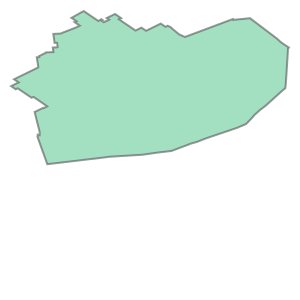

In [205]:
# shapefile['geometry'].iloc[0]

In [206]:
# shapefile['district'] = shapefile['SLDLST'].apply(lambda x: 'l'+x)
# leg_dist_areas = shapefile[['area', 'district']]

In [207]:
# shapefile = gpd.read_file("ny_data/senate_shapefiles/tl_2018_36_sldu.shp")
# # print (test.crs)
# shapefile.head(2)

# shapefile= shapefile.to_crs({'proj': 'cea'})
# shapefile["area"] = shapefile['geometry'].area/ 10**6
# shapefile.head(2)

,STATEFP,SLDUST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,area
0,36,049,36049,State Senate District 49,LU,2018,G5210,N,9742041586,510983642,+43.5002206,-074.5795437,"POLYGON ((-8367903.823 4418227.422, -8367791.6...",10253.02
1,36,017,36017,State Senate District 17,LU,2018,G5210,N,16347056,0,+40.6241942,-073.9737774,"POLYGON ((-8238967.911 4133558.578, -8238903.1...",16.35


In [208]:
# shapefile['district'] = shapefile['SLDUST'].apply(lambda x: 'u'+x)
# leg_dist_areas = pd.concat([leg_dist_areas, shapefile[['area', 'district']]])

In [209]:
# leg_dist_areas

,area,district
0,55.59,l059
1,14.31,l037
2,77.32,l137
3,315.43,l009
4,16.48,l033
...,...,...
58,165.10,u063
59,223.09,u024
60,2297.71,u041
61,5041.46,u046


In [210]:
# sample = pd.merge(sample, leg_dist_areas, how='left', on='district')

In [211]:
sample['pop_density_km'] = sample['Total Pop']/sample['area']
sample

,year,district,dem_net_vote,previous_winner_dem,Total Pop,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,...,"$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,generic_ballot,area,pop_density_km
0,2012.0,l002,-16146.0,0.0,125986,61397,64589,115303,4177,107,...,11740,10047,5204,22357,20553,74496,23499,-0.2,1753.99,71.83
1,2012.0,l003,239.0,0.0,129515,63192,66323,108201,11606,172,...,13421,11070,4762,14870,23420,83478,13824,-0.2,287.69,450.19
2,2012.0,l004,11577.0,1.0,128333,63694,64639,102795,7567,472,...,10354,8516,4879,21665,22277,82614,16207,-0.2,457.74,280.36
3,2012.0,l005,-7310.0,0.0,130292,64977,65315,116397,2877,137,...,12619,10676,5650,18883,24649,83642,14932,-0.2,100.81,1292.46
4,2012.0,l006,17148.0,1.0,130598,65399,65199,66302,24827,842,...,13638,8692,2722,7314,24889,84901,11359,-0.2,56.89,2295.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,2018.0,u053,13428.0,1.0,285981,137846,148135,221349,40799,1921,...,30787,21617,9038,23234,42179,183689,43614,7.3,2555.28,111.92
635,2018.0,u054,-25954.0,0.0,293440,144683,148757,269550,9029,809,...,34644,24533,10559,28317,45737,178626,53362,7.3,7279.89,40.31
636,2018.0,u058,-18673.0,0.0,289885,143670,146215,257519,10623,646,...,29373,21529,8235,23473,41524,184105,49300,7.3,6998.30,41.42
637,2018.0,u060,-12744.0,0.0,293136,140555,152581,246681,19162,2330,...,34973,25680,10509,33103,43418,183418,50301,7.3,1069.76,274.02
